In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import Union
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

In [9]:
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DDPM
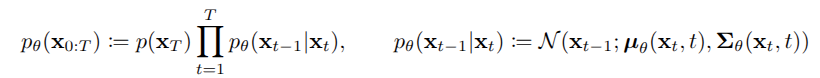
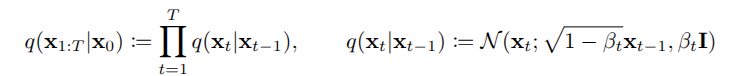
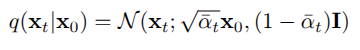
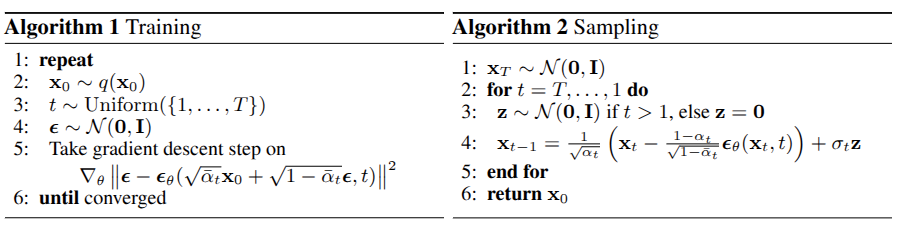

# TODO
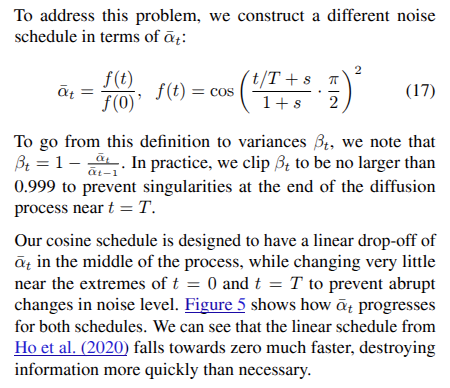

In [11]:
def gather(x: torch.Tensor, t: Union[int, torch.Tensor]):
    if isinstance(t, int):
        t = torch.tensor([t], dtype=torch.long, device=x.device)
    elif isinstance(t, list):
        t = torch.tensor(t, dtype=torch.long, device=x.device)
    elif isinstance(t, torch.Tensor):
        t = t.to(dtype=torch.long, device=x.device)
    else:
        raise ValueError("Unsupported type for t")

    temp = x.gather(0, t)
    return temp.reshape(-1, 1, 1, 1)


class DDPM:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.model = model
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

    def q(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Compute the forward diffusion process q(x_t | x_{t-1}).
        """
        alpha_bar_t = gather(self.alpha_bar, t)
        mean = torch.sqrt(alpha_bar_t) * x_0
        var = 1.0 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x_0, t, eps=None):
        """
        Sample from the forward diffusion process q(x_t | x_0).
        """
        if eps is None:
            eps = torch.randn_like(x_0)
        mean, var = self.q(x_0, t)
        return mean + torch.sqrt(var) * eps

    def p_sample(self, x_t, t):
        eps_theta = self.model(x_t, t)
        alpha_bar_t = gather(self.alpha_bar, t)
        alpha_t = gather(self.alphas, t)
        mean = (1.0 / torch.sqrt(alpha_t)) * (
            x_t - (1.0 - alpha_t) / torch.sqrt(1.0 - alpha_bar_t) * eps_theta
        )
        var = gather(self.betas, t)
        eps = torch.randn_like(x_t, device=self.device)
        return mean + torch.sqrt(var) * eps

    def loss(self, x_0, noise=None):
        """
        Compute the loss for the model.
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        t = torch.randint(0, self.n_steps, (x_0.size(0),), device=self.device)
        x_t = self.q_sample(x_0, t, noise)
        eps_theta = self.model(x_t, t)
        return F.mse_loss(eps_theta, noise)

    def sample(self, n_samples=1, image_size=(1, 28, 28), xt=None):
        if xt is not None:
            x_t = xt.to(self.device)
        else:
            x_t = torch.randn(n_samples, *image_size).to(self.device)

        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((n_samples,), t, device=self.device, dtype=torch.long)
            x_t = self.p_sample(x_t, t_batch)  # assumes p_sample does noise addition

        return torch.clamp(x_t, -1.0, 1.0)

# UNet
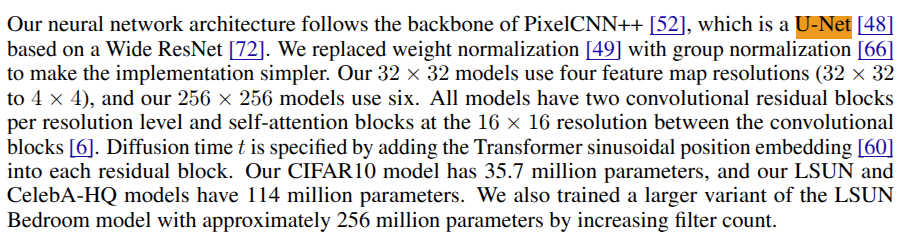
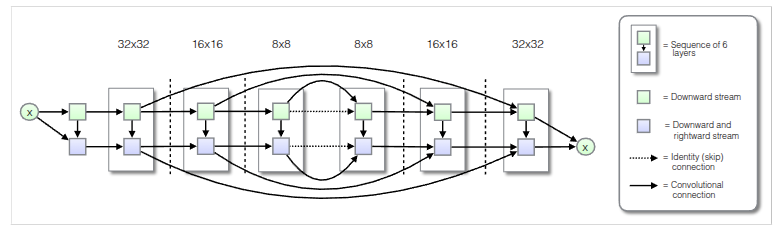

In [12]:
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_dim, groups=8):
        super().__init__()
        self.group_norm1 = nn.GroupNorm(groups, in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.group_norm2 = nn.GroupNorm(groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_emb = nn.Linear(time_dim, out_channels)
        self.residual_conv = (
            nn.Conv2d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, t):
        h = self.group_norm1(x)
        h = F.silu(h)
        h = self.conv1(h)
        h = self.group_norm2(h)
        h += self.time_emb(t)[:, :, None, None]
        h = F.silu(h)
        h = self.conv2(h)
        return h + self.residual_conv(x)


class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv2d(channels, channels, 1)
        self.k = nn.Conv2d(channels, channels, 1)
        self.v = nn.Conv2d(channels, channels, 1)
        self.proj_out = nn.Conv2d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x)
        q = self.q(h).view(B, C, -1).permute(0, 2, 1)
        k = self.k(h).view(B, C, -1)
        v = self.v(h).view(B, C, -1)

        attn = torch.bmm(q, k) * (C**-0.5)
        attn = F.softmax(attn, dim=-1)

        out = torch.bmm(v, attn.permute(0, 2, 1))
        out = out.view(B, C, H, W)
        return x + self.proj_out(out)


class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )

        # Downsampling
        self.down1 = nn.ModuleList(
            [
                ResidualBlock(in_channels, base_channels, time_dim, groups=1),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )
        self.down2 = nn.ModuleList(
            [
                ResidualBlock(base_channels, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels * 2, time_dim),
            ]
        )

        # Middle
        self.mid = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels * 4, time_dim),
                SelfAttentionBlock(base_channels * 4),
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
            ]
        )

        # Upsampling
        self.up2 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 4, base_channels * 2, time_dim),
                SelfAttentionBlock(base_channels * 2),
                ResidualBlock(base_channels * 2, base_channels, time_dim),
            ]
        )
        self.up1 = nn.ModuleList(
            [
                ResidualBlock(base_channels * 2, base_channels, time_dim),
                ResidualBlock(base_channels, base_channels, time_dim),
            ]
        )

        self.final_conv = nn.Conv2d(base_channels, out_channels, 3, padding=1)

        self.downsample = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t):
        t = self.time_mlp(t)
        x1 = []

        # Downsample path
        # Block 1 (28x28 -> 28x28)
        for block in self.down1:
            x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 14x14

        # Block 2 (14x14 -> 14x14)
        for block in self.down2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)
        x1.append(x)
        x = self.downsample(x)  # 7x7

        # Middle (7x7 -> 7x7)
        for block in self.mid:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Upsample path
        # Block 2 (7x7 -> 14x14)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up2:
            if isinstance(block, SelfAttentionBlock):
                x = block(x)
            else:
                x = block(x, t)

        # Block 1 (14x14 -> 28x28)
        x = self.upsample(x)
        x = torch.cat([x, x1.pop()], dim=1)
        for block in self.up1:
            x = block(x, t)

        return self.final_conv(x)


# model = UNet()
# x = torch.randn(8, 1, 28, 28)  # MNIST batch
# t = torch.randint(0, 1000, (8,))  # Random timesteps
# output = model(x, t)
# print(output.shape)  # Should be (8, 1, 28, 28)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009580255..0.9992703].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38605392..1.3538835].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7194772..1.5914325].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3066773..2.4032536].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2432079..2.5309517].


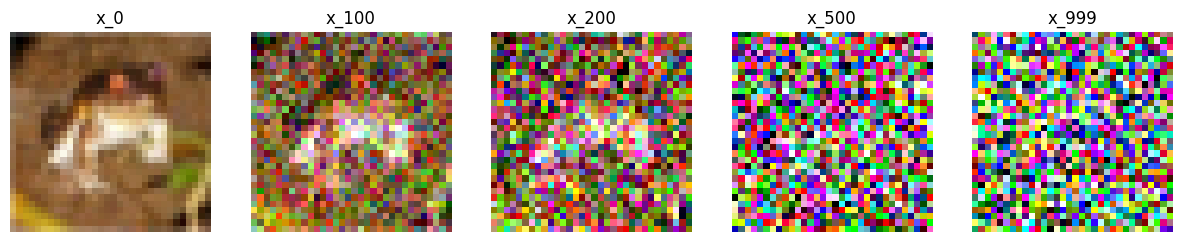

In [13]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

# Training Configuration
config = {
    "batch_size": 128,
    "epochs": 150,
    "lr": 2e-4,
    "n_steps": 1000,
    "weight_decay": 1e-5,
    "max_grad_norm": 1.0,
    "save_interval": 50,
}

# Data Preparation
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

# Model Initialization
model = UNet(in_channels=3, out_channels=3, base_channels=64).to(device)
diffusion = DDPM(model, device, n_steps=config["n_steps"])
optimizer = torch.optim.AdamW(
    model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config["epochs"]
)

img, _ = train_dataset[0]  # Get a transformed CelebA image
sampled_image = img.unsqueeze(0).to(device)  # Add batch dimension

timesteps = [0, 100, 200, 500, 999]
sampled_images = []

for t in timesteps:
    x_t = diffusion.q_sample(sampled_image, t=torch.tensor([t]).to(device))
    img = x_t.squeeze(0).cpu().permute(1, 2, 0) * 0.5 + 0.5  # Denormalize to [0,1]
    sampled_images.append(img)

# Plotting (adjust for RGB)
plt.figure(figsize=(15, 3))
for i, (t, img) in enumerate(zip(timesteps, sampled_images)):
    plt.subplot(1, len(timesteps), i + 1)
    plt.imshow(img)
    plt.title(f"x_{t}")
    plt.axis("off")
plt.show()

Epoch 1/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0765]


Epoch 1 | Avg Loss: 0.0919


Epoch 2/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0503]


Epoch 2 | Avg Loss: 0.0437


Epoch 3/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0354]


Epoch 3 | Avg Loss: 0.0397


Epoch 4/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0316]


Epoch 4 | Avg Loss: 0.0372


Epoch 5/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0448]


Epoch 5 | Avg Loss: 0.0368


Epoch 6/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0265]


Epoch 6 | Avg Loss: 0.0358


Epoch 7/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0407]


Epoch 7 | Avg Loss: 0.0354


Epoch 8/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0377]


Epoch 8 | Avg Loss: 0.0348


Epoch 9/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.0315]


Epoch 9 | Avg Loss: 0.0348


Epoch 10/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0246]


Epoch 10 | Avg Loss: 0.0342


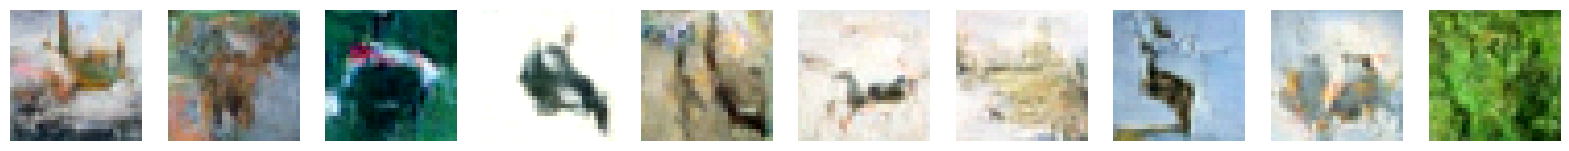

Epoch 11/150: 100%|██████████| 391/391 [00:18<00:00, 20.83it/s, Loss=0.0475]


Epoch 11 | Avg Loss: 0.0341


Epoch 12/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.0456]


Epoch 12 | Avg Loss: 0.0339


Epoch 13/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.0351]


Epoch 13 | Avg Loss: 0.0336


Epoch 14/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.0174]


Epoch 14 | Avg Loss: 0.0334


Epoch 15/150: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s, Loss=0.0398]


Epoch 15 | Avg Loss: 0.0332


Epoch 16/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.0282]


Epoch 16 | Avg Loss: 0.0331


Epoch 17/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0389]


Epoch 17 | Avg Loss: 0.0331


Epoch 18/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0202]


Epoch 18 | Avg Loss: 0.0326


Epoch 19/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0425]


Epoch 19 | Avg Loss: 0.0329


Epoch 20/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0284]


Epoch 20 | Avg Loss: 0.0324


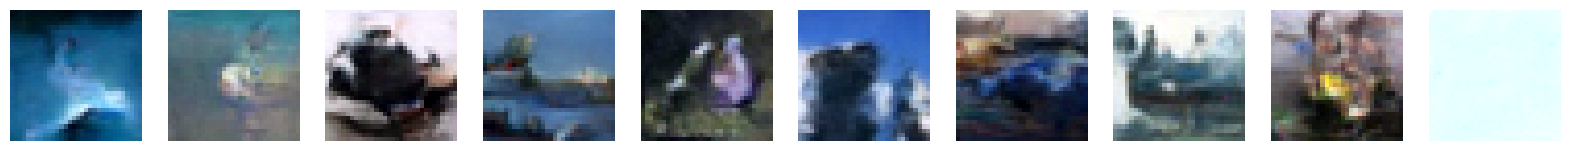

Epoch 21/150: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s, Loss=0.0334]


Epoch 21 | Avg Loss: 0.0331


Epoch 22/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0304]


Epoch 22 | Avg Loss: 0.0331


Epoch 23/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0438]


Epoch 23 | Avg Loss: 0.0327


Epoch 24/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0160]


Epoch 24 | Avg Loss: 0.0323


Epoch 25/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0282]


Epoch 25 | Avg Loss: 0.0327


Epoch 26/150: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s, Loss=0.0295]


Epoch 26 | Avg Loss: 0.0323


Epoch 27/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0322]


Epoch 27 | Avg Loss: 0.0325


Epoch 28/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.0308]


Epoch 28 | Avg Loss: 0.0319


Epoch 29/150: 100%|██████████| 391/391 [00:18<00:00, 21.30it/s, Loss=0.0305]


Epoch 29 | Avg Loss: 0.0315


Epoch 30/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.0194]


Epoch 30 | Avg Loss: 0.0314


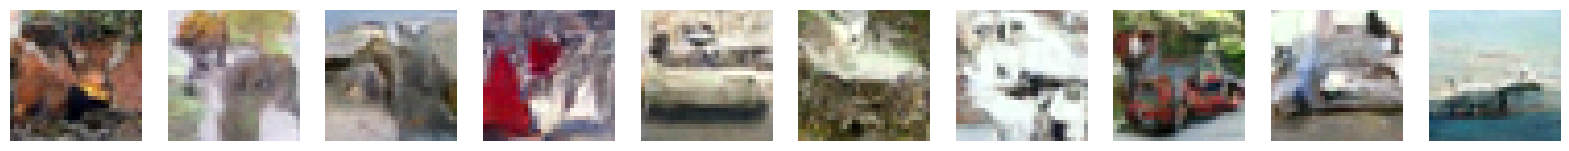

Epoch 31/150: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s, Loss=0.0508]


Epoch 31 | Avg Loss: 0.0326


Epoch 32/150: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s, Loss=0.0385]


Epoch 32 | Avg Loss: 0.0313


Epoch 33/150: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s, Loss=0.0323]


Epoch 33 | Avg Loss: 0.0317


Epoch 34/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.0226]


Epoch 34 | Avg Loss: 0.0319


Epoch 35/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.0299]


Epoch 35 | Avg Loss: 0.0319


Epoch 36/150: 100%|██████████| 391/391 [00:18<00:00, 21.54it/s, Loss=0.0381]


Epoch 36 | Avg Loss: 0.0320


Epoch 37/150: 100%|██████████| 391/391 [00:17<00:00, 21.89it/s, Loss=0.0305]


Epoch 37 | Avg Loss: 0.0316


Epoch 38/150: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s, Loss=0.0287]


Epoch 38 | Avg Loss: 0.0314


Epoch 39/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.0368]


Epoch 39 | Avg Loss: 0.0318


Epoch 40/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.0271]


Epoch 40 | Avg Loss: 0.0315


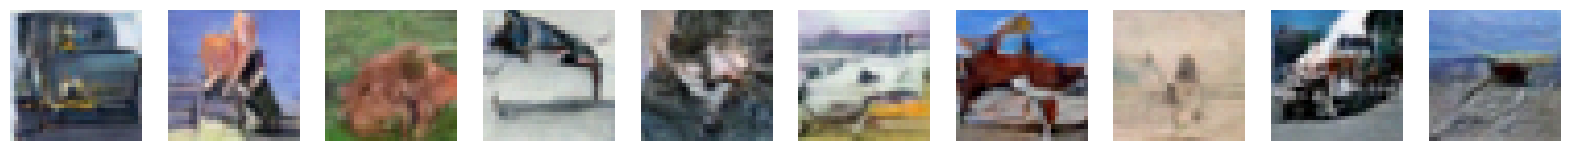

Epoch 41/150: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s, Loss=0.0314]


Epoch 41 | Avg Loss: 0.0316


Epoch 42/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.0302]


Epoch 42 | Avg Loss: 0.0315


Epoch 43/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.0330]


Epoch 43 | Avg Loss: 0.0317


Epoch 44/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.0247]


Epoch 44 | Avg Loss: 0.0310


Epoch 45/150: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s, Loss=0.0227]


Epoch 45 | Avg Loss: 0.0320


Epoch 46/150: 100%|██████████| 391/391 [00:18<00:00, 21.63it/s, Loss=0.0290]


Epoch 46 | Avg Loss: 0.0313


Epoch 47/150: 100%|██████████| 391/391 [00:18<00:00, 21.61it/s, Loss=0.0257]


Epoch 47 | Avg Loss: 0.0311


Epoch 48/150: 100%|██████████| 391/391 [00:18<00:00, 21.30it/s, Loss=0.0280]


Epoch 48 | Avg Loss: 0.0306


Epoch 49/150: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s, Loss=0.0298]


Epoch 49 | Avg Loss: 0.0314


Epoch 50/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0304]


Epoch 50 | Avg Loss: 0.0312


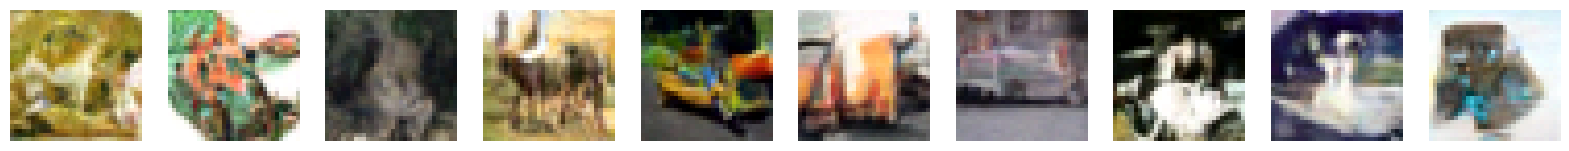

Epoch 51/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0243]


Epoch 51 | Avg Loss: 0.0306


Epoch 52/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0276]


Epoch 52 | Avg Loss: 0.0309


Epoch 53/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0319]


Epoch 53 | Avg Loss: 0.0313


Epoch 54/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0134]


Epoch 54 | Avg Loss: 0.0311


Epoch 55/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0251]


Epoch 55 | Avg Loss: 0.0315


Epoch 56/150: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s, Loss=0.0233]


Epoch 56 | Avg Loss: 0.0311


Epoch 57/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0270]


Epoch 57 | Avg Loss: 0.0307


Epoch 58/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0312]


Epoch 58 | Avg Loss: 0.0311


Epoch 59/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0294]


Epoch 59 | Avg Loss: 0.0306


Epoch 60/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0450]


Epoch 60 | Avg Loss: 0.0310


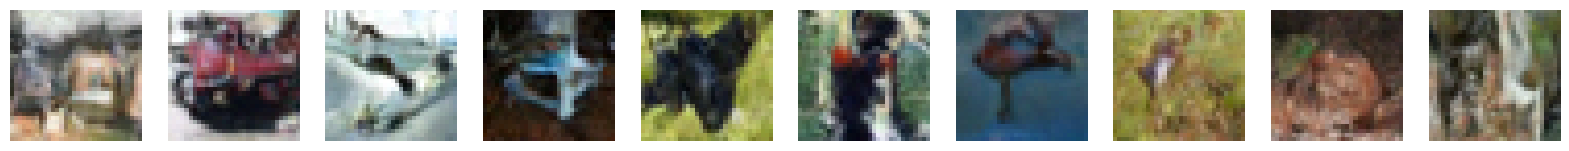

Epoch 61/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0254]


Epoch 61 | Avg Loss: 0.0313


Epoch 62/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0228]


Epoch 62 | Avg Loss: 0.0308


Epoch 63/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0272]


Epoch 63 | Avg Loss: 0.0311


Epoch 64/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0251]


Epoch 64 | Avg Loss: 0.0314


Epoch 65/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0380]


Epoch 65 | Avg Loss: 0.0309


Epoch 66/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.0274]


Epoch 66 | Avg Loss: 0.0309


Epoch 67/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0213]


Epoch 67 | Avg Loss: 0.0307


Epoch 68/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0229]


Epoch 68 | Avg Loss: 0.0308


Epoch 69/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0280]


Epoch 69 | Avg Loss: 0.0309


Epoch 70/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0362]


Epoch 70 | Avg Loss: 0.0313


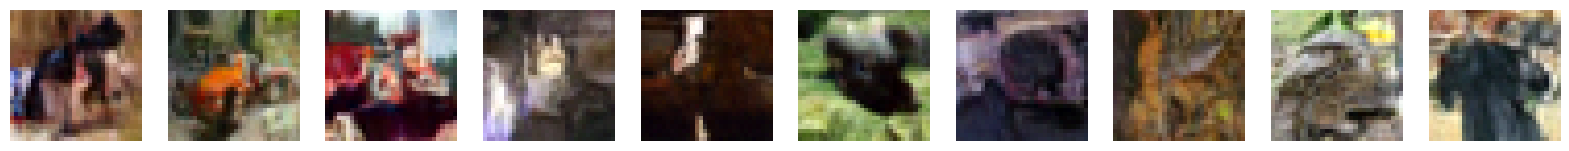

Epoch 71/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0302]


Epoch 71 | Avg Loss: 0.0310


Epoch 72/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.0422]


Epoch 72 | Avg Loss: 0.0308


Epoch 73/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0415]


Epoch 73 | Avg Loss: 0.0308


Epoch 74/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0393]


Epoch 74 | Avg Loss: 0.0307


Epoch 75/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0377]


Epoch 75 | Avg Loss: 0.0310


Epoch 76/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0251]


Epoch 76 | Avg Loss: 0.0309


Epoch 77/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.0235]


Epoch 77 | Avg Loss: 0.0306


Epoch 78/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0365]


Epoch 78 | Avg Loss: 0.0306


Epoch 79/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0190]


Epoch 79 | Avg Loss: 0.0309


Epoch 80/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.0337]


Epoch 80 | Avg Loss: 0.0306


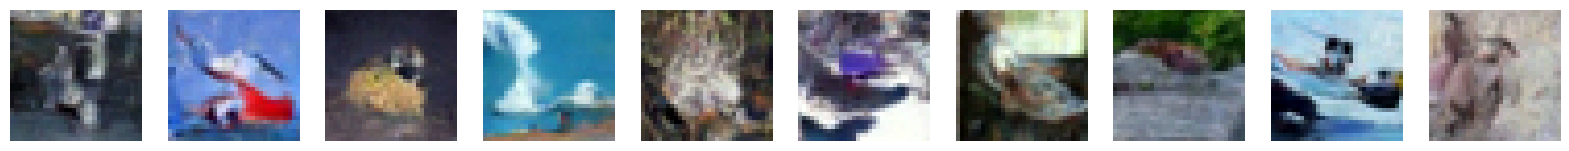

Epoch 81/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0358]


Epoch 81 | Avg Loss: 0.0306


Epoch 82/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.0362]


Epoch 82 | Avg Loss: 0.0310


Epoch 83/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0261]


Epoch 83 | Avg Loss: 0.0303


Epoch 84/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0340]


Epoch 84 | Avg Loss: 0.0308


Epoch 85/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0510]


Epoch 85 | Avg Loss: 0.0309


Epoch 86/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0282]


Epoch 86 | Avg Loss: 0.0305


Epoch 87/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.0305]


Epoch 87 | Avg Loss: 0.0310


Epoch 88/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.0317]


Epoch 88 | Avg Loss: 0.0305


Epoch 89/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0235]


Epoch 89 | Avg Loss: 0.0307


Epoch 90/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0338]


Epoch 90 | Avg Loss: 0.0307


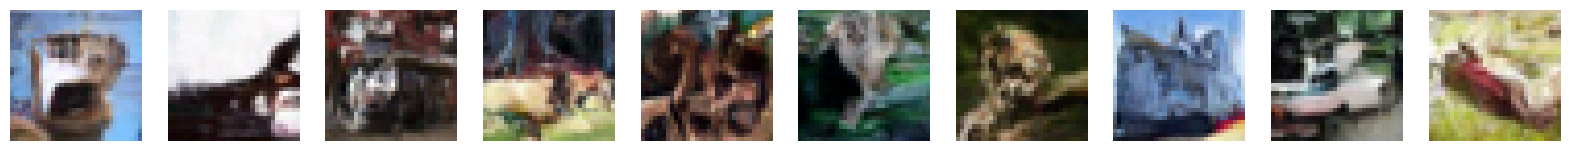

Epoch 91/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0293]


Epoch 91 | Avg Loss: 0.0305


Epoch 92/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0234]


Epoch 92 | Avg Loss: 0.0303


Epoch 93/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0292]


Epoch 93 | Avg Loss: 0.0307


Epoch 94/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0253]


Epoch 94 | Avg Loss: 0.0299


Epoch 95/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0370]


Epoch 95 | Avg Loss: 0.0307


Epoch 96/150: 100%|██████████| 391/391 [00:18<00:00, 20.86it/s, Loss=0.0249]


Epoch 96 | Avg Loss: 0.0308


Epoch 97/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.0303]


Epoch 97 | Avg Loss: 0.0309


Epoch 98/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0350]


Epoch 98 | Avg Loss: 0.0305


Epoch 99/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0177]


Epoch 99 | Avg Loss: 0.0308


Epoch 100/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0299]


Epoch 100 | Avg Loss: 0.0301


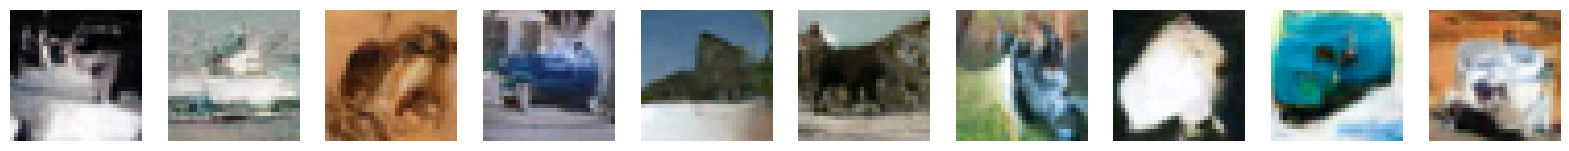

Epoch 101/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0299]


Epoch 101 | Avg Loss: 0.0303


Epoch 102/150: 100%|██████████| 391/391 [00:18<00:00, 21.00it/s, Loss=0.0196]


Epoch 102 | Avg Loss: 0.0305


Epoch 103/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0284]


Epoch 103 | Avg Loss: 0.0308


Epoch 104/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0367]


Epoch 104 | Avg Loss: 0.0301


Epoch 105/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0236]


Epoch 105 | Avg Loss: 0.0307


Epoch 106/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0364]


Epoch 106 | Avg Loss: 0.0307


Epoch 107/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.0267]


Epoch 107 | Avg Loss: 0.0305


Epoch 108/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0278]


Epoch 108 | Avg Loss: 0.0307


Epoch 109/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0147]


Epoch 109 | Avg Loss: 0.0301


Epoch 110/150: 100%|██████████| 391/391 [00:18<00:00, 20.96it/s, Loss=0.0336]


Epoch 110 | Avg Loss: 0.0300


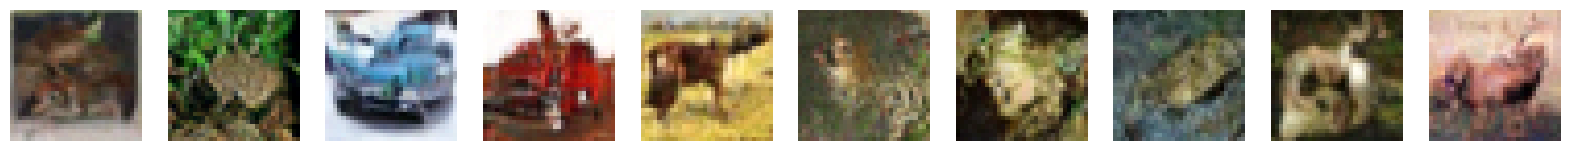

Epoch 111/150: 100%|██████████| 391/391 [00:18<00:00, 20.84it/s, Loss=0.0271]


Epoch 111 | Avg Loss: 0.0300


Epoch 112/150: 100%|██████████| 391/391 [00:18<00:00, 20.82it/s, Loss=0.0262]


Epoch 112 | Avg Loss: 0.0308


Epoch 113/150: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s, Loss=0.0256]


Epoch 113 | Avg Loss: 0.0302


Epoch 114/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0262]


Epoch 114 | Avg Loss: 0.0306


Epoch 115/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0226]


Epoch 115 | Avg Loss: 0.0298


Epoch 116/150: 100%|██████████| 391/391 [00:18<00:00, 20.93it/s, Loss=0.0299]


Epoch 116 | Avg Loss: 0.0301


Epoch 117/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0380]


Epoch 117 | Avg Loss: 0.0308


Epoch 118/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0254]


Epoch 118 | Avg Loss: 0.0304


Epoch 119/150: 100%|██████████| 391/391 [00:18<00:00, 21.02it/s, Loss=0.0443]


Epoch 119 | Avg Loss: 0.0303


Epoch 120/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0283]


Epoch 120 | Avg Loss: 0.0302


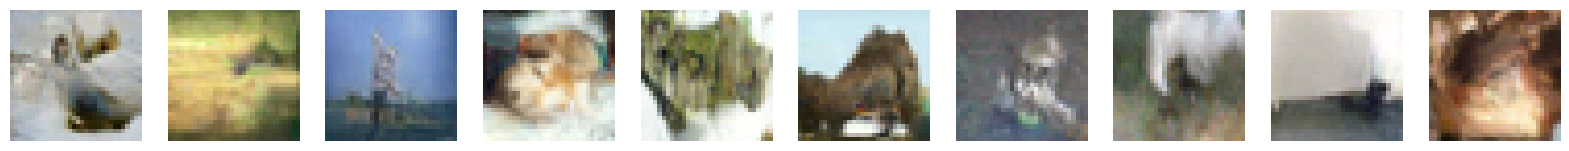

Epoch 121/150: 100%|██████████| 391/391 [00:18<00:00, 20.87it/s, Loss=0.0347]


Epoch 121 | Avg Loss: 0.0304


Epoch 122/150: 100%|██████████| 391/391 [00:18<00:00, 20.88it/s, Loss=0.0431]


Epoch 122 | Avg Loss: 0.0305


Epoch 123/150: 100%|██████████| 391/391 [00:18<00:00, 20.94it/s, Loss=0.0340]


Epoch 123 | Avg Loss: 0.0302


Epoch 124/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0272]


Epoch 124 | Avg Loss: 0.0306


Epoch 125/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0316]


Epoch 125 | Avg Loss: 0.0304


Epoch 126/150: 100%|██████████| 391/391 [00:18<00:00, 20.85it/s, Loss=0.0386]


Epoch 126 | Avg Loss: 0.0303


Epoch 127/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0402]


Epoch 127 | Avg Loss: 0.0304


Epoch 128/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0292]


Epoch 128 | Avg Loss: 0.0303


Epoch 129/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0247]


Epoch 129 | Avg Loss: 0.0302


Epoch 130/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0285]


Epoch 130 | Avg Loss: 0.0301


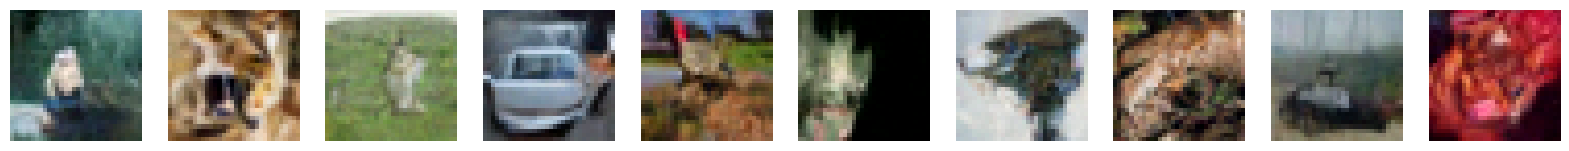

Epoch 131/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0180]


Epoch 131 | Avg Loss: 0.0303


Epoch 132/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0294]


Epoch 132 | Avg Loss: 0.0300


Epoch 133/150: 100%|██████████| 391/391 [00:18<00:00, 20.91it/s, Loss=0.0261]


Epoch 133 | Avg Loss: 0.0304


Epoch 134/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.0377]


Epoch 134 | Avg Loss: 0.0301


Epoch 135/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0307]


Epoch 135 | Avg Loss: 0.0300


Epoch 136/150: 100%|██████████| 391/391 [00:18<00:00, 20.95it/s, Loss=0.0168]


Epoch 136 | Avg Loss: 0.0299


Epoch 137/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0213]


Epoch 137 | Avg Loss: 0.0301


Epoch 138/150: 100%|██████████| 391/391 [00:18<00:00, 21.01it/s, Loss=0.0388]


Epoch 138 | Avg Loss: 0.0303


Epoch 139/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0362]


Epoch 139 | Avg Loss: 0.0300


Epoch 140/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0214]


Epoch 140 | Avg Loss: 0.0303


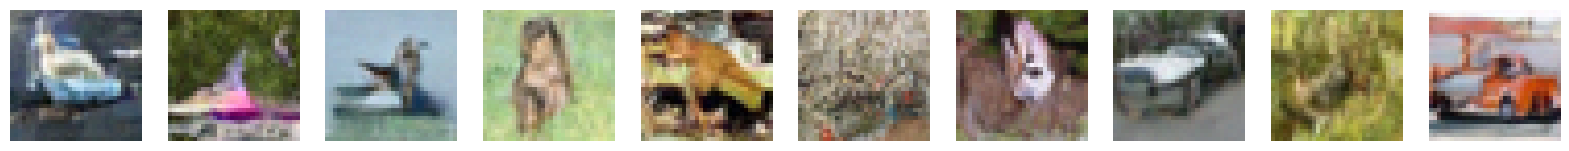

Epoch 141/150: 100%|██████████| 391/391 [00:18<00:00, 20.98it/s, Loss=0.0407]


Epoch 141 | Avg Loss: 0.0303


Epoch 142/150: 100%|██████████| 391/391 [00:18<00:00, 20.90it/s, Loss=0.0212]


Epoch 142 | Avg Loss: 0.0301


Epoch 143/150: 100%|██████████| 391/391 [00:18<00:00, 20.89it/s, Loss=0.0356]


Epoch 143 | Avg Loss: 0.0303


Epoch 144/150: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s, Loss=0.0330]


Epoch 144 | Avg Loss: 0.0299


Epoch 145/150: 100%|██████████| 391/391 [00:18<00:00, 20.97it/s, Loss=0.0440]


Epoch 145 | Avg Loss: 0.0301


Epoch 146/150: 100%|██████████| 391/391 [00:18<00:00, 20.92it/s, Loss=0.0360]


Epoch 146 | Avg Loss: 0.0303


Epoch 147/150: 100%|██████████| 391/391 [00:10<00:00, 36.69it/s, Loss=0.0327]


Epoch 147 | Avg Loss: 0.0300


Epoch 148/150: 100%|██████████| 391/391 [00:09<00:00, 41.85it/s, Loss=0.0390]


Epoch 148 | Avg Loss: 0.0302


Epoch 149/150: 100%|██████████| 391/391 [00:09<00:00, 41.76it/s, Loss=0.0234]


Epoch 149 | Avg Loss: 0.0304


Epoch 150/150: 100%|██████████| 391/391 [00:09<00:00, 41.72it/s, Loss=0.0262]


Epoch 150 | Avg Loss: 0.0306


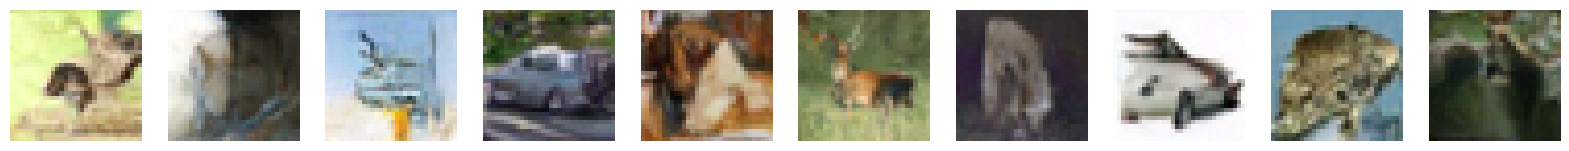

Training completed!


In [14]:
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
best_loss = float("inf")
for epoch in range(config["epochs"]):
    model.train()
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['epochs']}")
    total_loss = 0

    for images, _ in pbar:
        images = images.to(device)
        optimizer.zero_grad()
        loss = diffusion.loss(images)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config["max_grad_norm"])
        optimizer.step()
        total_loss += loss.item()
        pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

    scheduler.step()
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")

    # Sampling and Saving
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            sampled_images = diffusion.sample(n_samples=10, image_size=(3, 32, 32))
            sampled_images = torch.clamp(sampled_images, -1.0, 1.0)
            plt.figure(figsize=(20, 4))
            for i in range(10):
                plt.subplot(1, 10, i + 1)
                img = sampled_images[i].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)
                plt.imshow(img)
                plt.axis("off")
            plt.show()

torch.save(model.state_dict(), "ddpm_cifar10_final.pth")
print("Training completed!")